In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cmocean
import veros.core.density.nonlinear_eq2 as neq2
from matplotlib import colors
import plotting_function_avg as pltfunc
import diagnostic_function as diagf
from matplotlib.gridspec import GridSpec
import matplotlib.gridspec as gridspec
import xgcm
from matplotlib.lines import Line2D
from labellines import labelLines


Importing core modules
 Using computational backend numpy on cpu
 Runtime settings are now locked



In [3]:
def axis_depth_long_two_fields(axis, field, field_color_name, field_lines_name, span, norm='Normalize', levels = 31, labeled_levels = [-5000], wlabels=True, cmap = "cmo.balance", neg_pos = False):
    vmin, vmax = span
    linestyle_neg = 'solid'
    if neg_pos :
        linestyle_neg = 'dashed'
        
    if norm=='Normalize':
        norm = colors.Normalize(vmin=vmin, vmax=vmax)
    elif norm=='TwoSlopeNorm':
        norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

    contour = field_color_name.plot.contourf(ax=axis, levels=levels, norm=norm, cmap=cmap, add_colorbar=False)
    
    field_color_name.where(field_color_name > 0).plot.contour(ax=axis, norm=norm, levels=levels, colors='k', linestyles='solid', alpha=0.15)
    field_color_name.where(field_color_name <= 0).plot.contour(ax=axis, norm=norm, levels=levels, colors='k', linestyles=linestyle_neg, alpha=0.1)
    
    labeled_contour_lines_neg = field_lines_name.where(field_lines_name <= 0).plot.contour(ax=axis, levels=labeled_levels, colors='k', linestyles=linestyle_neg, alpha=0.5)
    labeled_contour_lines_pos = field_lines_name.where(field_lines_name > 0).plot.contour(ax=axis, levels=labeled_levels, colors='k', linestyles='solid', alpha=0.5)
    if wlabels :
        axis.clabel(labeled_contour_lines_neg, levels=labeled_levels, fmt="%.2f", inline=True, fontsize=8, colors="black")
        axis.clabel(labeled_contour_lines_pos, levels=labeled_levels, fmt="%.2f", inline=True, fontsize=8, colors="black")
    #axis.set_title(field + rf' - {field_color_name.years:.0f}y') 
    #ax.set_xlim(-70,0)

    return contour

In [4]:
dir_name_clim = "/home/x_titmo/work/runs_output/NW2_clim/"
dir_name_clim_ER = "/home/x_titmo/work/runs_output/NW2_clim/Z_End_run/"

# Averages 
ds_Clim_bis = xr.open_mfdataset(dir_name_clim + "/Dino_clim_bis/Dino_clim_bis_suite/nw2_dino.0024.averages.nc", decode_times=False)
ds_Long_2SO = xr.open_mfdataset(dir_name_clim + "/Long_2SO/Long_2SO_suite/nw2_dino.0078.averages.nc", decode_times=False) #running
ds_Long_3SO = xr.open_mfdataset(dir_name_clim + "/Long_SO/Long_SO_suite_2/nw2_dino.0052.averages.nc", decode_times=False) #running


datasets_avg = {"Clim": ds_Clim_bis, "2SO" : ds_Long_2SO,  "3SO" : ds_Long_3SO,
                }

# Snapshots
ds_Clim_bis_snap = xr.open_mfdataset(dir_name_clim + "/Dino_clim_bis/Dino_clim_bis_suite/nw2_dino.0024.snapshot.nc", decode_times=False)
ds_Long_2SO_snap = xr.open_mfdataset(dir_name_clim + "/Long_2SO/Long_2SO_suite/nw2_dino.0078.snapshot.nc", decode_times=False) #running
ds_Long_3SO_snap = xr.open_mfdataset(dir_name_clim + "/Long_SO/Long_SO_suite_2/nw2_dino.0052.snapshot.nc", decode_times=False) #running

datasets_snap = {"Clim": ds_Clim_bis_snap, "2SO" : ds_Long_2SO_snap,  "3SO" : ds_Long_3SO_snap,

                }
# Overturning
ds_Clim_bis_ovr = xr.open_mfdataset(dir_name_clim + "/Dino_clim_bis/Dino_clim_bis_suite/nw2_dino.0024.overturning.nc", decode_times=False)
ds_Long_2SO_ovr = xr.open_mfdataset(dir_name_clim + "/Long_2SO/Long_2SO_suite/nw2_dino.0078.overturning.nc", decode_times=False) #running
ds_Long_3SO_ovr = xr.open_mfdataset(dir_name_clim + "/Long_SO/Long_SO_suite_2/nw2_dino.0052.overturning.nc", decode_times=False) #running


datasets_ovr = {"Clim": ds_Clim_bis_ovr, "2SO" : ds_Long_2SO_ovr,  "3SO" : ds_Long_3SO_ovr,
                }

ds_snap = ds_Clim_bis_snap

style = {
    "Clim": {"color": "tab:orange", "linestyle": "solid"},
    "NoW":      {"color": "tab:green", "linestyle": "solid"},
    "Futur":      {"color": "tab:red", "linestyle": "solid"},

    "2W":    {"color": "tab:red", "linestyle": "solid"},
    "2W_SO": {"color": "tab:blue", "linestyle": (0, (1, 1, 1, 5))},
    "2W_N":  {"color": "tab:blue", "linestyle": (0, (5, 5))},

    "Mix_Mean": {"color": "tab:purple", "linestyle": "dotted"},
    "Mix_Min":  {"color": "tab:purple", "linestyle": "dashed"},
    "Mix_Max":  {"color": "tab:purple", "linestyle": "solid"},

    "2SO":      {"color": "tab:blue", "linestyle": "solid"},
    "3SO":      {"color": "tab:cyan", "linestyle": "solid"}, 

    }

keys_to_plot = ["Clim", "2SO", "3SO",]

In [5]:
for key in keys_to_plot :
    if key=="pass":
        continue
    datasets_avg[key]  = datasets_avg[key].assign_coords(years=("Time", (datasets_avg[key].Time / 365).data))
    datasets_ovr[key]  = datasets_ovr[key].assign_coords(years=("Time", (datasets_ovr[key].Time / 365.).data))
    datasets_snap[key] = datasets_snap[key].assign_coords(years=("Time", (datasets_snap[key].Time / 365.).data))

dict_weights = {}
for key in keys_to_plot :
    ds = datasets_snap[key]
    land_mask = (ds.zt.to_numpy()[:,np.newaxis, np.newaxis] <= -ds.bathymetry.to_numpy()[np.newaxis,...]) | (ds.salt.isel(Time=0).drop_vars("Time") == np.nan)
    weight_xyz_t = (1-land_mask) * ds.area_t * ds.dzt
    weight_xyz_t = weight_xyz_t.fillna(0) / weight_xyz_t.sum()
    weights_xy_t = weight_xyz_t / weight_xyz_t.sum('xt').sum('yt')
    weights_z_t = weight_xyz_t.mean(dim=('xt','yt'))

    land_mask_W = xr.DataArray(land_mask.values, dims=('zw', 'yt', 'xt'), coords={'zw': ds.zw, 'yt': ds.yt, 'xt': ds.xt})

    weight_xyz_w = (1-land_mask_W) * ds.area_t * ds.dzw
    weight_xyz_w = weight_xyz_w.fillna(0) / weight_xyz_w.sum()
    weights_xy_w = weight_xyz_w / weight_xyz_w.sum('xt').sum('yt')
    weights_z_w = weight_xyz_w.mean(dim=('xt','yt'))

    weight_surf = ds.area_t.fillna(0)
    weight_surf =weight_surf/ weight_surf.sum('xt').sum('yt')

    dict_weights[key] = {"land_mask": land_mask,
                         "weight_xyz_t" : weight_xyz_t,
                         "weights_xy_t" : weights_xy_t,
                         "weights_z_t" : weights_z_t,
                         "land_mask_W" : land_mask_W,
                         "weight_xyz_w" : weight_xyz_w,
                         "weights_xy_w" : weights_xy_w,
                         "weights_z_w" : weights_z_w,
                         "weight_surf" : weight_surf,
                         }

In [6]:
dict_field_zonal_mean_s = {}
dict_field_zonal_mean_t = {}
dict_field_zonal_mean_rho_anomaly = {}
dict_field_zonal_mean_prho = {}
dict_field_zeta_2000 = {}
dict_field_mld = {}
dict_field_bsf = {}
dict_field_Nsqr = {}
dict_salt_flux = {}
dict_temp_flux = {}

for key, ds in datasets_avg.items():
    if key=='pass':
        continue
    ytp = 1500
    weight_xyz_t = dict_weights[key]["weight_xyz_t"]
    salinity = ds["salt"].isel(Time=slice(100,120))
    temperature = ds["temp"].isel(Time=slice(100,120))

    rho = neq2.nonlin2_eq_of_state_rho(salinity, temperature, -ds_snap.zt)
    prho = neq2.nonlin2_eq_of_state_rho(salinity, temperature, 0) +neq2.rho0 -1000.
    mld = diagf.mean_mld(prho)
    rho_avg = neq2.nonlin2_eq_of_state_rho(salinity.weighted(weight_xyz_t).mean(dim=('xt', 'yt', 'zt')), temperature.weighted(weight_xyz_t).mean(dim=('xt', 'yt', 'zt')), -ds_snap.zt) 
    rho_anomaly = rho - rho_avg

    cond = (ds_snap.zt > -2000) & (((1-land_mask)*ds_snap.zt).min(dim='zt')<-2000)
    zeta_2000, zeta_temp_2000, zeta_salt_2000 = diagf.heigth_anomaly_CoM(salinity.where(cond), 
                                                            temperature.where(cond),
                                                            salinity.where(cond).weighted(weight_xyz_t).mean(dim=("xt","yt","zt")), 
                                                            temperature.where(cond).weighted(weight_xyz_t).mean(dim=("xt","yt","zt")), 
                                                            ds_snap.zt.where(cond), 
                                                            z_v= -1000)
    
    #Nsqr_T, Nsqr_S, N_sqr = diagf.Nsqr_decomposed_Time(temperature, ds_snap.dzt, salinity, ds_snap.zt, ds_snap.zw)
    #N_sqr = N_sqr.expand_dims({"years": [ytp]}).sel(years=ytp)

    dict_field_zonal_mean_s[key] = salinity.where(ds.salt.xt<50).mean(dim='Time').weighted(weight_xyz_t).mean(dim=('xt'))
    dict_field_zonal_mean_t[key] = temperature.where(ds.salt.xt<50).mean(dim='Time').weighted(weight_xyz_t).mean(dim=('xt'))
    dict_field_zonal_mean_rho_anomaly[key] = rho_anomaly.mean(dim='Time').weighted(weight_xyz_t).mean(dim=('xt'))
    dict_field_zonal_mean_prho[key] = prho.where(ds.salt.xt<50).mean(dim='Time').weighted(weight_xyz_t).mean(dim=('xt'))
    dict_field_zeta_2000[key] = zeta_2000.mean(dim='Time').weighted(weight_xyz_t).mean(dim=('zt'))
    dict_field_mld[key] = mld.mean(dim='Time')
    dict_field_bsf[key] = (ds.psi * 1e-6).mean(dim='Time')#.sel(Time=ytp * 365, method="nearest")
    #dict_field_Nsqr[key] = N_sqr.mean(dim='Time').where(N_sqr.zw>-2000).weighted(weight_xyz_w).mean(dim=('zw'))

    def alpha_beta(temp, salt, zt):
        rho =  neq2.nonlin2_eq_of_state_rho(salt, temp, -zt) + neq2.rho0
        drho_dct = neq2.nonlin2_eq_of_state_drhodT(temp, -zt)
        drho_dsa = neq2.nonlin2_eq_of_state_drhodS()
    
        alpha = -(1 / rho) * drho_dct
        beta = (1 / rho) * drho_dsa
        return alpha, beta
    
    # alpha, beta = alpha_beta(temperature, salinity, ds_snap.zt)

    # dict_temp_flux[key] = alpha.isel(zt=-1) * datasets_avg[key].forc_temp_surface.sel(Time=ytp * 365, method="nearest")
    # dict_salt_flux[key] = beta.isel(zt=-1)  * datasets_avg[key].forc_salt_surface.sel(Time=ytp * 365, method="nearest")

In [7]:
dict_pycnocline_4000={}

for key, ds in datasets_avg.items():
    if key=="pass":
        continue
    ytp = 1500
    land_mask = dict_weights[key]["land_mask"]
    weight_xyz_t = dict_weights[key]["weight_xyz_t"]
    weight_surf = dict_weights[key]["weight_surf"]

    z_bottom_mask = datasets_snap[key].zt.where(datasets_snap[key].zt > -4000).min()
    mask_4000 = (datasets_snap[key].zt >= z_bottom_mask) & (((1-land_mask)*datasets_snap[key].zt).min(dim='zt')<= z_bottom_mask)
    #mask_H = (1-land_mask).sel(zt=-H, method='nearest')
    #ds.temp.zt.where(mask_4000).weighted(weight_xyz_t).mean(dim=("zt")).plot()

    zmean_4000 = ds.temp.zt.where(mask_4000).weighted(weight_xyz_t).mean(dim=("xt","yt","zt"))
    #print(zmean_4000.values, z_bottom_mask.values/2)

    #zmean_4000 = -2000
    salinity_pyc = ds["salt"].isel(Time=slice(100,120)).mean(dim=('Time')).where(ds.salt.xt<50).where(mask_4000)
    temperature_pyc = ds["temp"].isel(Time=slice(100,120)).mean(dim=('Time')).where(ds.salt.xt<50).where(mask_4000)

    #Pycnocline H=4000m, zv=-2000m (env)
    meridional_pic_fab_4000, zonavg_depth_anomaly_approx_4000, zonavg_mean_N2_approx_4000, H_plus_4000, H_thin_4000 = diagf.pycnocline_fab(salinity_pyc, temperature_pyc, -2*zmean_4000, datasets_snap[key].zt, weight_surf, weight_xyz_t, land_mask)
    meridional_pic_gna_4000, zonavg_numer_4000, zonavg_denum_4000  = diagf.pycnocline_gnanadesikan(salinity_pyc, temperature_pyc, -2*zmean_4000, datasets_snap[key].zt, weight_surf, weight_xyz_t, land_mask)
    
    dict_pycnocline_4000[key] = {"pic_fab": meridional_pic_fab_4000,
                            "zonavg_depth_anomaly_approx" : zonavg_depth_anomaly_approx_4000,
                            "zonavg_mean_N2_approx" : zonavg_mean_N2_approx_4000,
                            "H_plus" : H_plus_4000,
                            "H_thin" : H_thin_4000.weighted(weight_surf).mean(dim=("xt",)),
                            "H_thin_map" : H_thin_4000,
                            "pic_gna" : meridional_pic_gna_4000,
                            "zonavg_numer" : zonavg_numer_4000,
                            "zonavg_denum" : zonavg_denum_4000,
                            }



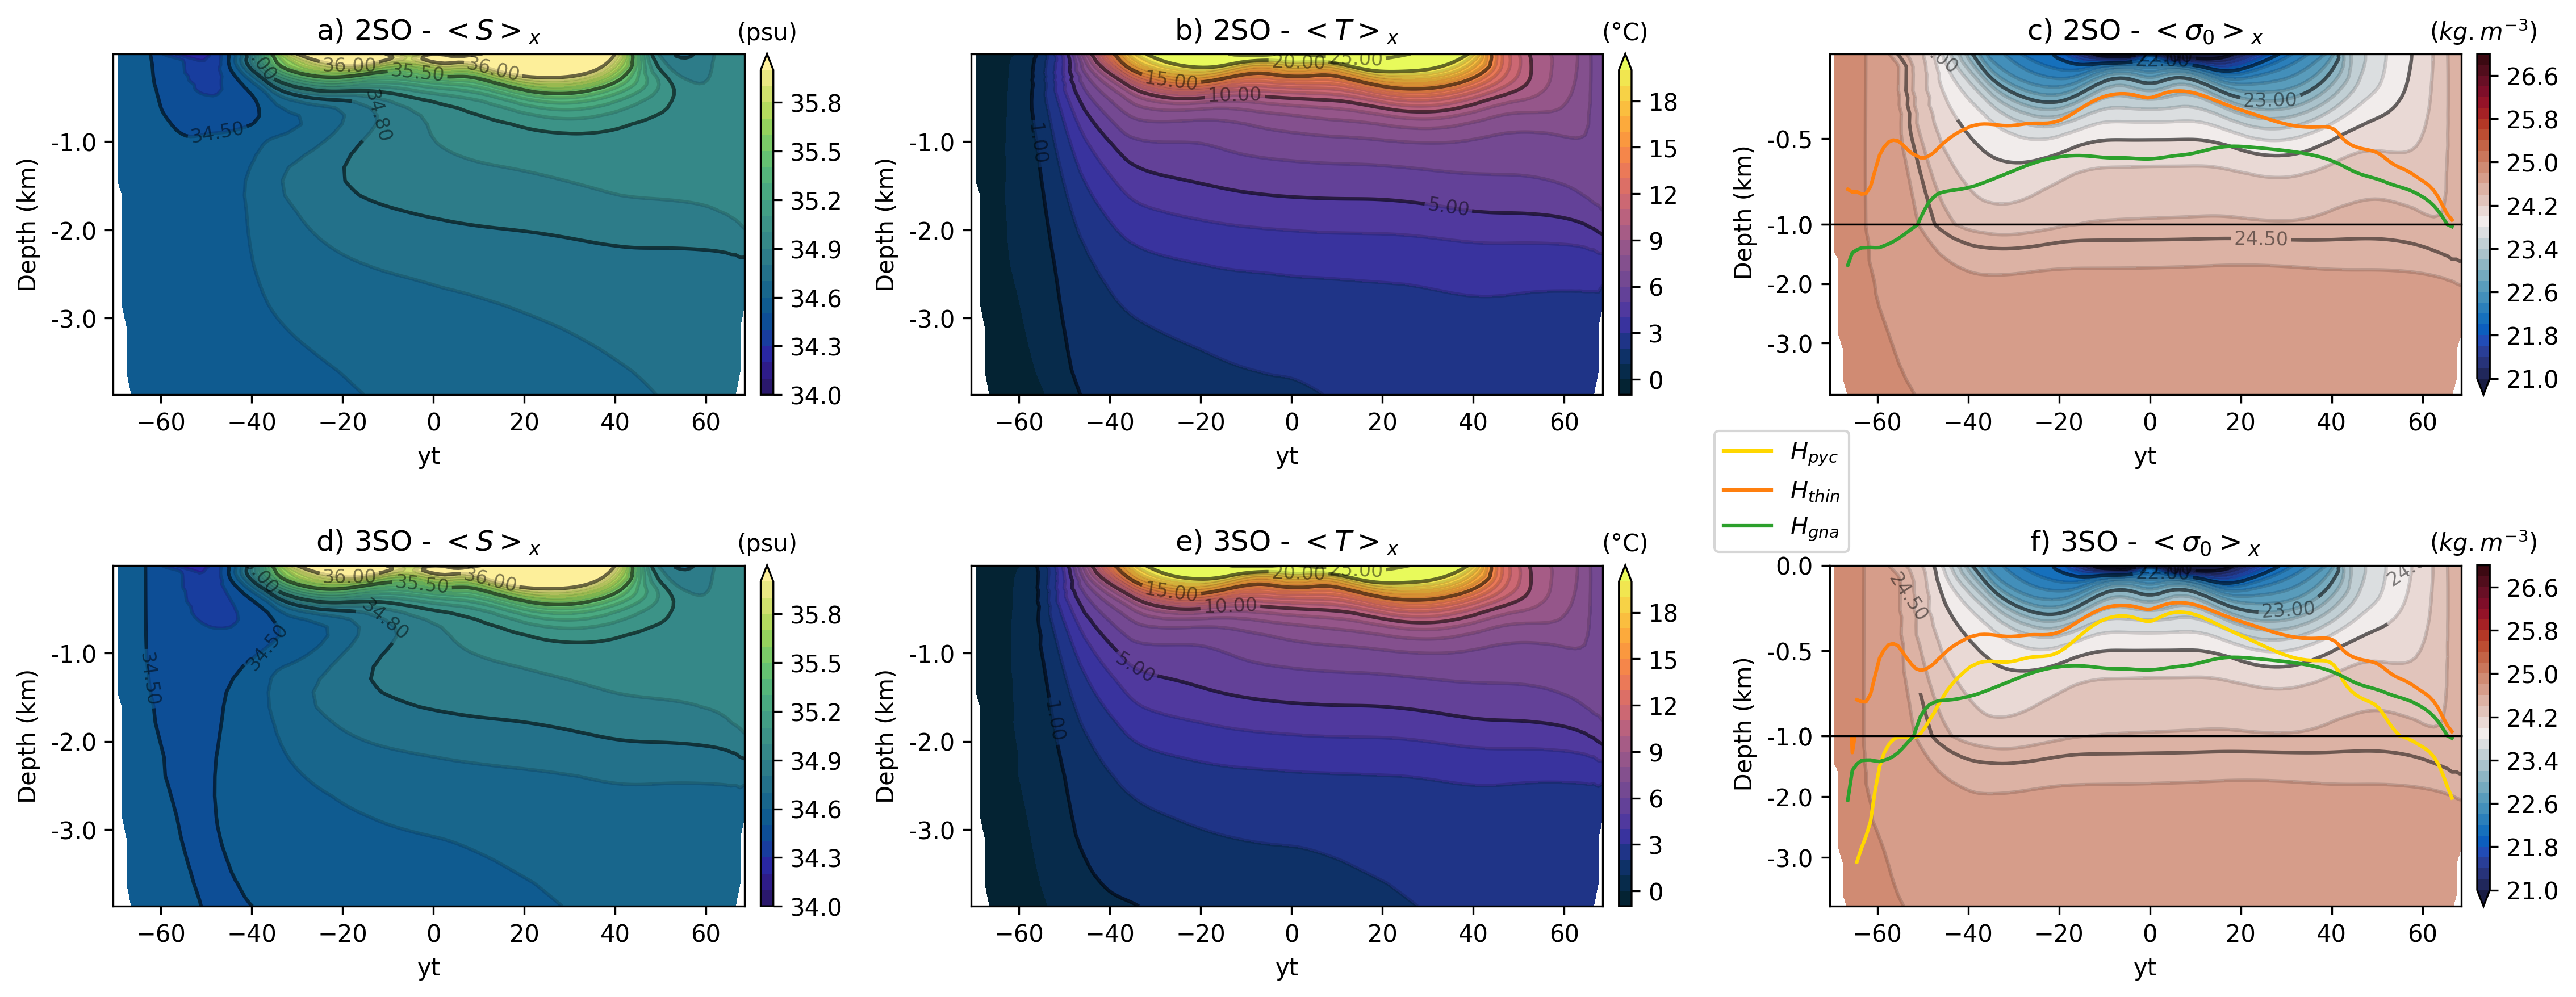

In [8]:
fig = plt.figure(figsize=(18,6.5), dpi=300)
######TOP######
gs = gridspec.GridSpec(2, 1, figure=fig, width_ratios=[1], height_ratios=[1,1], hspace = 0.5)
gs_top = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs[0], width_ratios=[1,1,1], height_ratios=[1], wspace=0.3, hspace = 0.5)
gs_bot = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs[1], width_ratios=[1,1,1], height_ratios=[1], wspace=0.3, hspace = 0.5)

gs1 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs_top[0], width_ratios=[1, 0.02], wspace = 0.05)
ax1 = fig.add_subplot(gs1[0])
cax1 = fig.add_subplot(gs1[1])
ax1_labeled_levels = [34.0, 34.5, 34.8, 35., 35.5, 36.,]
contour1 = axis_depth_long_two_fields(ax1, "zonal_mean_s", dict_field_zonal_mean_s["2SO"], dict_field_zonal_mean_s["2SO"], span = (34,36), norm='Normalize', levels = 21, labeled_levels = ax1_labeled_levels, cmap = "cmo.haline", neg_pos = False)
fig.colorbar(contour1, cax=cax1, orientation='vertical')
#cax_t.set_title(field)

gs2 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs_top[1], width_ratios=[1, 0.02], wspace = 0.05)
ax2 = fig.add_subplot(gs2[0])
cax2 = fig.add_subplot(gs2[1])
contour2 = axis_depth_long_two_fields(ax2, "zonal_mean_t", dict_field_zonal_mean_t["2SO"], dict_field_zonal_mean_t["2SO"], span = (-1, 20), norm='Normalize', levels = 22, labeled_levels = [1., 5., 10., 15., 20., 25., 30.], cmap="cmo.thermal")
fig.colorbar(contour2, cax=cax2, orientation='vertical')


gs3 = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs_top[2], width_ratios=[1, 0.02], wspace = 0.05, hspace=0)
ax3_up = fig.add_subplot(gs3[0,0])
ax3_down = fig.add_subplot(gs3[1,0])
cax3 = fig.add_subplot(gs3[:,1])
contour3_up = axis_depth_long_two_fields(ax3_up, "zonal_mean_rho_anomaly", dict_field_zonal_mean_prho["2SO"], dict_field_zonal_mean_prho["2SO"], span = (21,27), norm='Normalize', levels = 31, labeled_levels = [21., 22., 23., 24., 24.5, 25., 26, 27.], cmap="cmo.balance")
contour3_down = axis_depth_long_two_fields(ax3_down, "zonal_mean_rho_anomaly", dict_field_zonal_mean_prho["2SO"], dict_field_zonal_mean_prho["2SO"], span = (21,27), norm='Normalize', levels = 31, labeled_levels = [21., 22., 23., 24., 24.5, 25., 26, 27.], cmap="cmo.balance")
fig.colorbar(contour3_up, cax=cax3, orientation='vertical')
H_thin_contour = dict_pycnocline_4000["2SO"]["H_thin"].sel(yt=slice(None, None)).plot(ax=ax3_up, color='tab:orange', linewidth=1.5, label=r'$H_{thin}$')
H_gna_contour = (-dict_pycnocline_4000["2SO"]["pic_gna"]).sel(yt=slice(None, None)).plot(ax=ax3_up, color='tab:green', linewidth=1.5, label=r'$H_{gna}$')
dict_pycnocline_4000["2SO"]["H_thin"].sel(yt=slice(None, None)).plot(ax=ax3_down, color='tab:orange', linewidth=1.5, label=r'$H_{thin}$')
(-dict_pycnocline_4000["2SO"]["pic_gna"]).sel(yt=slice(None, None)).plot(ax=ax3_down, color='tab:green', linewidth=1.5, label=r'$H_{gna}$')
ax3_up.set_ylim(-1000,None), ax3_down.set_ylim(None,-1000)

ax_left=[ax1, ax2, ax3_up, ax3_down]
titles =[r"a) 2SO - $<S>_x$", r"b) 2SO - $<T>_x$", r"c) 2SO - $<\sigma_0>_x$", ""]
i=0
for axis in ax_left :
    axis.set_yticklabels([f"{(tick/1000):.1f}" for tick in axis.get_yticks()])
    axis.set_ylabel('Depth (km)')
    axis.set_title(titles[i])
    i+=1
ax3_down.set_ylabel('                          Depth (km)'), ax3_up.set_ylabel('')


caxis = [cax1, cax2, cax3]
titles_cax=['(psu)', '(°C)', r'($kg.m^{-3}$)', '(m)', r'($s^{-1}$)']
i=0
for cax in caxis : 
    cax.set_title(titles_cax[i],fontsize=10.)
    i+=1



######BOTTOM######
gs1 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs_bot[0], width_ratios=[1, 0.02], wspace = 0.05)
ax1 = fig.add_subplot(gs1[0])
cax1 = fig.add_subplot(gs1[1])
ax1_labeled_levels = [34.0, 34.5, 34.8, 35., 35.5, 36.,]
contour1 = axis_depth_long_two_fields(ax1, "zonal_mean_s", dict_field_zonal_mean_s["3SO"], dict_field_zonal_mean_s["3SO"], span = (34,36), norm='Normalize', levels = 21, labeled_levels = ax1_labeled_levels, cmap = "cmo.haline", neg_pos = False)
fig.colorbar(contour1, cax=cax1, orientation='vertical')
#cax_t.set_title(field)

gs2 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs_bot[1], width_ratios=[1, 0.02], wspace = 0.05)
ax2 = fig.add_subplot(gs2[0])
cax2 = fig.add_subplot(gs2[1])
contour2 = axis_depth_long_two_fields(ax2, "zonal_mean_t", dict_field_zonal_mean_t["3SO"], dict_field_zonal_mean_t["3SO"], span = (-1, 20), norm='Normalize', levels = 22, labeled_levels = [1., 5., 10., 15., 20., 25., 30.], cmap="cmo.thermal")
fig.colorbar(contour2, cax=cax2, orientation='vertical')


gs3 = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs_bot[2], width_ratios=[1, 0.02], wspace = 0.05, hspace=0)
ax3_up = fig.add_subplot(gs3[0,0])
ax3_down = fig.add_subplot(gs3[1,0])
cax3 = fig.add_subplot(gs3[:,1])
contour3_up = axis_depth_long_two_fields(ax3_up, "zonal_mean_rho_anomaly", dict_field_zonal_mean_prho["3SO"], dict_field_zonal_mean_prho["3SO"], span = (21,27), norm='Normalize', levels = 31, labeled_levels = [21., 22., 23., 24., 24.5, 25., 26, 27.], cmap="cmo.balance")
contour3_down = axis_depth_long_two_fields(ax3_down, "zonal_mean_rho_anomaly", dict_field_zonal_mean_prho["3SO"], dict_field_zonal_mean_prho["3SO"], span = (21,27), norm='Normalize', levels = 31, labeled_levels = [21., 22., 23., 24., 24.5, 25., 26, 27.], cmap="cmo.balance")
fig.colorbar(contour3_up, cax=cax3, orientation='vertical')
H_plus_contour = (-dict_pycnocline_4000["3SO"]["H_plus"]).sel(yt=slice(-65, None)).plot(ax=ax3_up, color='gold', linewidth=1.5, label=r'$H_{pyc}$')
H_thin_contour = dict_pycnocline_4000["3SO"]["H_thin"].sel(yt=slice(-65, None)).plot(ax=ax3_up, color='tab:orange', linewidth=1.5, label=r'$H_{thin}$')
H_gna_contour = (-dict_pycnocline_4000["3SO"]["pic_gna"]).sel(yt=slice(None, None)).plot(ax=ax3_up, color='tab:green', linewidth=1.5, label=r'$H_{gna}$')
dict_pycnocline_4000["3SO"]["H_thin"].sel(yt=slice(None, None)).plot(ax=ax3_down, color='tab:orange', linewidth=1.5)
(-dict_pycnocline_4000["3SO"]["H_plus"]).sel(yt=slice(-65, None)).plot(ax=ax3_down, color='gold', linewidth=1.5)
(-dict_pycnocline_4000["3SO"]["pic_gna"]).sel(yt=slice(None, None)).plot(ax=ax3_down, color='tab:green', linewidth=1.5)
ax3_up.set_ylim(-1000,0), ax3_down.set_ylim(-3800,-1000)

ax_left=[ax1, ax2, ax3_up, ax3_down]
titles =[r"d) 3SO - $<S>_x$", r"e) 3SO - $<T>_x$", r"f) 3SO - $<\sigma_0>_x$", ""]
i=0
for axis in ax_left :
    axis.set_yticklabels([f"{(tick/1000):.1f}" for tick in axis.get_yticks()])
    axis.set_ylabel('Depth (km)')
    axis.set_title(titles[i])
    i+=1
ax3_down.set_ylabel('                          Depth (km)'), ax3_up.set_ylabel('')
ax3_up.legend(loc='lower right', bbox_to_anchor=(0.05, 1.01))

caxis = [cax1, cax2, cax3]
titles_cax=['(psu)', '(°C)', r'($kg.m^{-3}$)', '(m)', r'($s^{-1}$)']
i=0
for cax in caxis : 
    cax.set_title(titles_cax[i],fontsize=10.)
    i+=1


plt.tight_layout()
path_to_plot = f"/home/x_titmo/work/analysis/NeverWorld2/plots/report/"
#plt.savefig(path_to_plot + f'NoW_Clim_1000y_TSprho.png', bbox_inches='tight')

plt.show()

In [9]:
dict_field_moc = {}
dict_field_eddies = {}
dict_field_rmoc = {}
dict_field_ssh = {}

ytp = 1500.
for key, ds in datasets_ovr.items():
    if key=="pass":
        continue    
    dict_field_moc[key] = -(ds.vsf_depth * 1e-6).sel(Time=ytp * 365, method="nearest")
    dict_field_eddies[key] = -(ds.bolus_depth * 1e-6).sel(Time=ytp * 365, method="nearest")
    dict_field_rmoc[key] = (dict_field_moc[key] + dict_field_eddies[key])
    #dict_field_ssh[key] = ds.p_hydro_here.sel(Time=ytp * 365, method="nearest").isel(zt=-1) / (neq2.rho0 * neq2.grav)

In [10]:
def plot_rmoc_axis(axis, field, field_color_name, field_lines_name, span, norm='Normalize', levels = 31, labeled_levels = [-5000], wlabels=True, cmap = "cmo.balance", neg_pos = False):
    vmin, vmax = span
    linestyle_neg = 'solid'
    if neg_pos :
        linestyle_neg = 'dashed'
        
    if norm=='Normalize':
        norm = colors.Normalize(vmin=vmin, vmax=vmax)
    elif norm=='TwoSlopeNorm':
        norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

    contour = field_color_name.plot.contourf(ax=axis, levels=levels, norm=norm, cmap=cmap, add_colorbar=False)
    
    field_color_name.where(field_color_name > 0).plot.contour(ax=axis, norm=norm, levels=levels, colors='k', linestyles='solid', alpha=0.15)
    field_color_name.where(field_color_name <= 0).plot.contour(ax=axis, norm=norm, levels=levels, colors='k', linestyles=linestyle_neg, alpha=0.1)
    
    labeled_contour_lines_neg = field_lines_name.where(field_lines_name.yt <= 1).plot.contour(ax=axis, levels=labeled_levels, colors='k', linestyles='solid', alpha=0.7)
    labeled_contour_lines_pos = field_lines_name.where(field_lines_name.yt >= 0).plot.contour(ax=axis, levels=labeled_levels, colors='k', linestyles='solid', alpha=0.7)
    axis.clabel(labeled_contour_lines_pos, levels=labeled_levels, fmt="%.2f", inline=True, fontsize=8, colors="black")
    #axis.set_title(field + rf' - {field_color_name.years:.0f}y') 
    #ax.set_xlim(-70,0)

    return contour

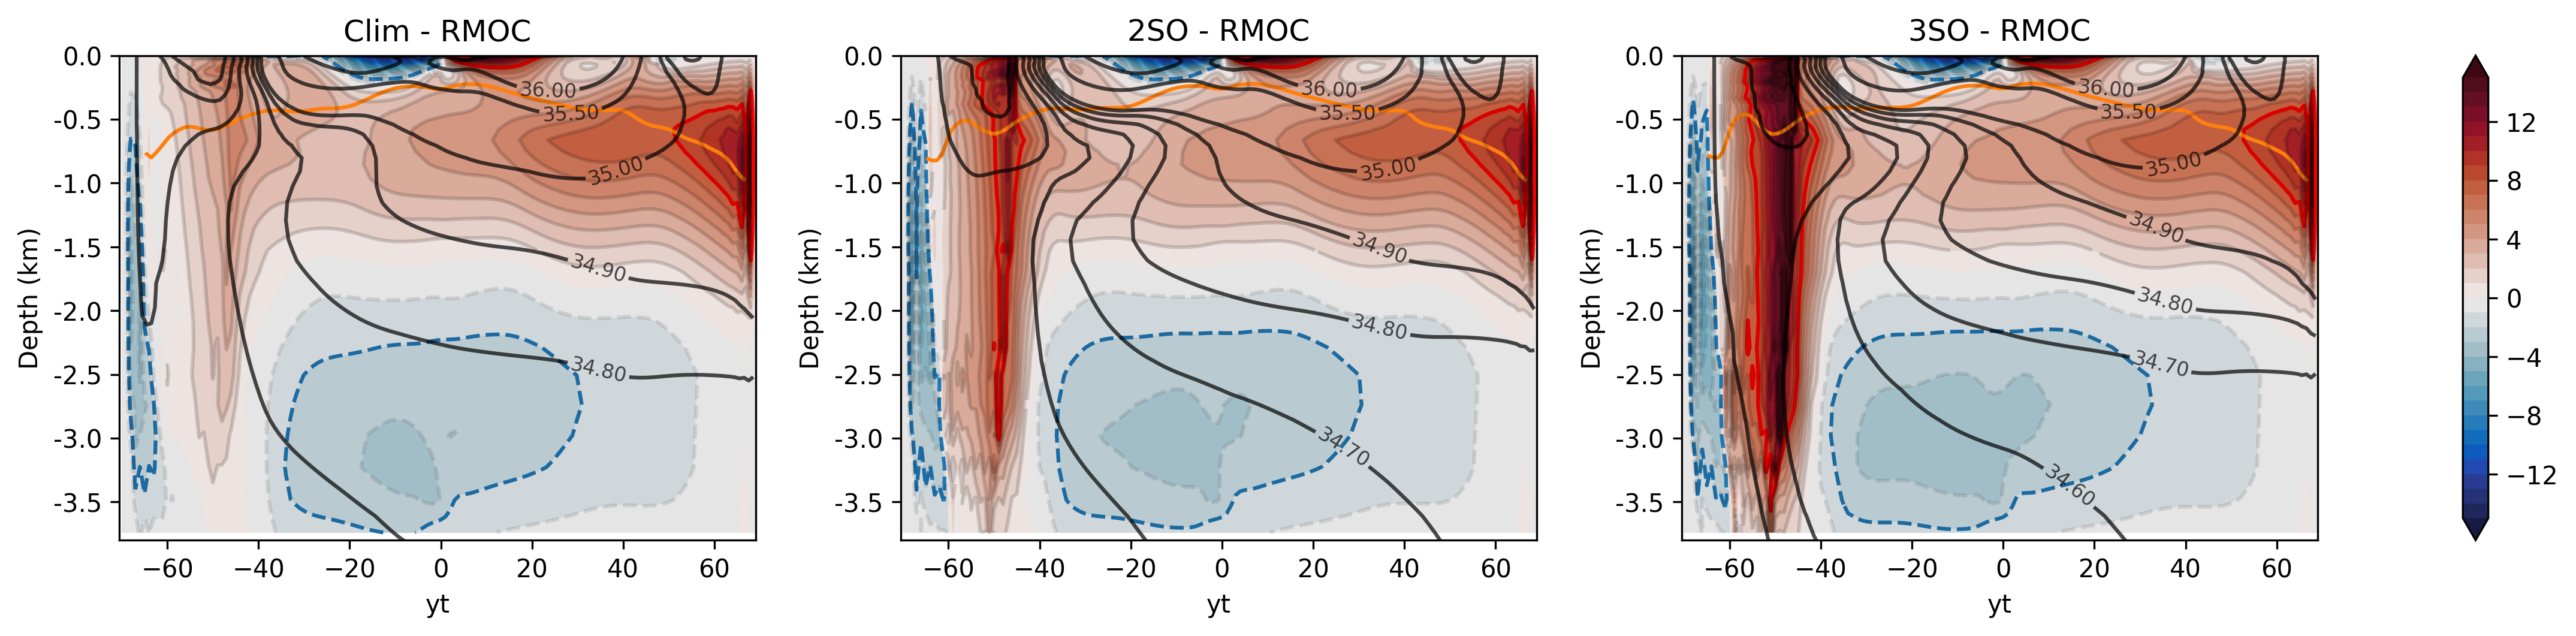

In [11]:
fig = plt.figure(figsize=(17,3.5), dpi=300)
gs = gridspec.GridSpec(1, 1, figure=fig, height_ratios=[1], hspace=0.2)

gs_top = gs[0].subgridspec(1, 4, width_ratios=[1, 1, 1, 0.04],  wspace=0.3, hspace=0.5)
subfield = "_rmoc"

for idx, key in enumerate([ "Clim","2SO", "3SO"]):
    if key == "pass" or key=='pass':
        continue
    row, col = divmod(idx, 3)
    gs_row_col = gs_top[row,col].subgridspec(1, 1, height_ratios = [1], hspace=0)
    ax_up = fig.add_subplot(gs_row_col[0])
    # ax_down = fig.add_subplot(gs_row_col[1])
    
    
    labeled_contour_lines_up = dict_field_rmoc[key].plot.contour(ax=ax_up, levels=[8], colors='r', linestyles='solid', alpha=1)
    # labeled_contour_lines_down = dict_field_rmoc[key].plot.contour(ax=ax_down, levels=[8], colors='tab:red', linestyles='solid', alpha=1)

    labeled_contour_lines_up = dict_field_rmoc[key].plot.contour(ax=ax_up, levels=[-2], colors='tab:blue', linestyles='dashed', alpha=1)
    # labeled_contour_lines_down = dict_field_rmoc[key].plot.contour(ax=ax_down, levels=[-2], colors='tab:blue', linestyles='dashed', alpha=1)
    
    H_thin_contour = (dict_pycnocline_4000[key]["H_thin"]).sel(yt=slice(-65, None)).plot(ax=ax_up, color='tab:orange', linewidth=1.5, label=r'$H_{thin}$')

    contour_up = plot_rmoc_axis(ax_up, r"RMOC - " + key, dict_field_rmoc[key], dict_field_zonal_mean_s[key], span = (-15,15),
                                            norm='Normalize', levels = 31, labeled_levels = [34.0, 34.4, 34.5, 34.6, 34.7, 34.8, 34.9, 35., 35.5, 36.,], wlabels=False, cmap = "cmo.balance", neg_pos = True)
    # contour_down = plot_rmoc_axis(ax_down, r"", dict_field_rmoc[key], dict_field_zonal_mean_s[key], span = (-15,15),
    #                                           norm='Normalize', levels = 31, labeled_levels = [34.0, 34.5, 34.6, 34.7, 34.8, 34.9, 35., 35.5, 36.,], wlabels=False, cmap = "cmo.balance", neg_pos = True)
    

    #axis.clabel(labeled_contour_lines_up, levels=[8], fmt="%.2f", inline=True, fontsize=8, colors="tab:red")
    ax_up.set_ylim(-3800,0)

    # ax_up.set_ylim(-2000,0)
    # ax_down.set_ylim(None,-2000)
    # ax_up.set_yticks([-1500, -1000, -500,-250,0])
    # ax_down.set_xlabel("")
    ax_up.set_ylabel("")
    # ax_down.set_ylabel("                  Depth (m)")
    # ax_down.set_title('')
    ax_up.set_title(key + " - RMOC")
    ax_up.set_yticklabels([f"{(tick/1000):.1f}" for tick in ax_up.get_yticks()])
    ax_up.set_ylabel('Depth (km)')

cax = fig.add_subplot(gs_top[:,3])  # Span the first two rows for temperature colorbar
fig.colorbar(contour_up, cax=cax, orientation='vertical')

plt.tight_layout()
path_to_plot = f"/home/x_titmo/work/analysis/NeverWorld2/plots/report/"
#plt.savefig(path_to_plot + f'Winds_RMOC_salt_1000y.png', bbox_inches='tight')

plt.show()


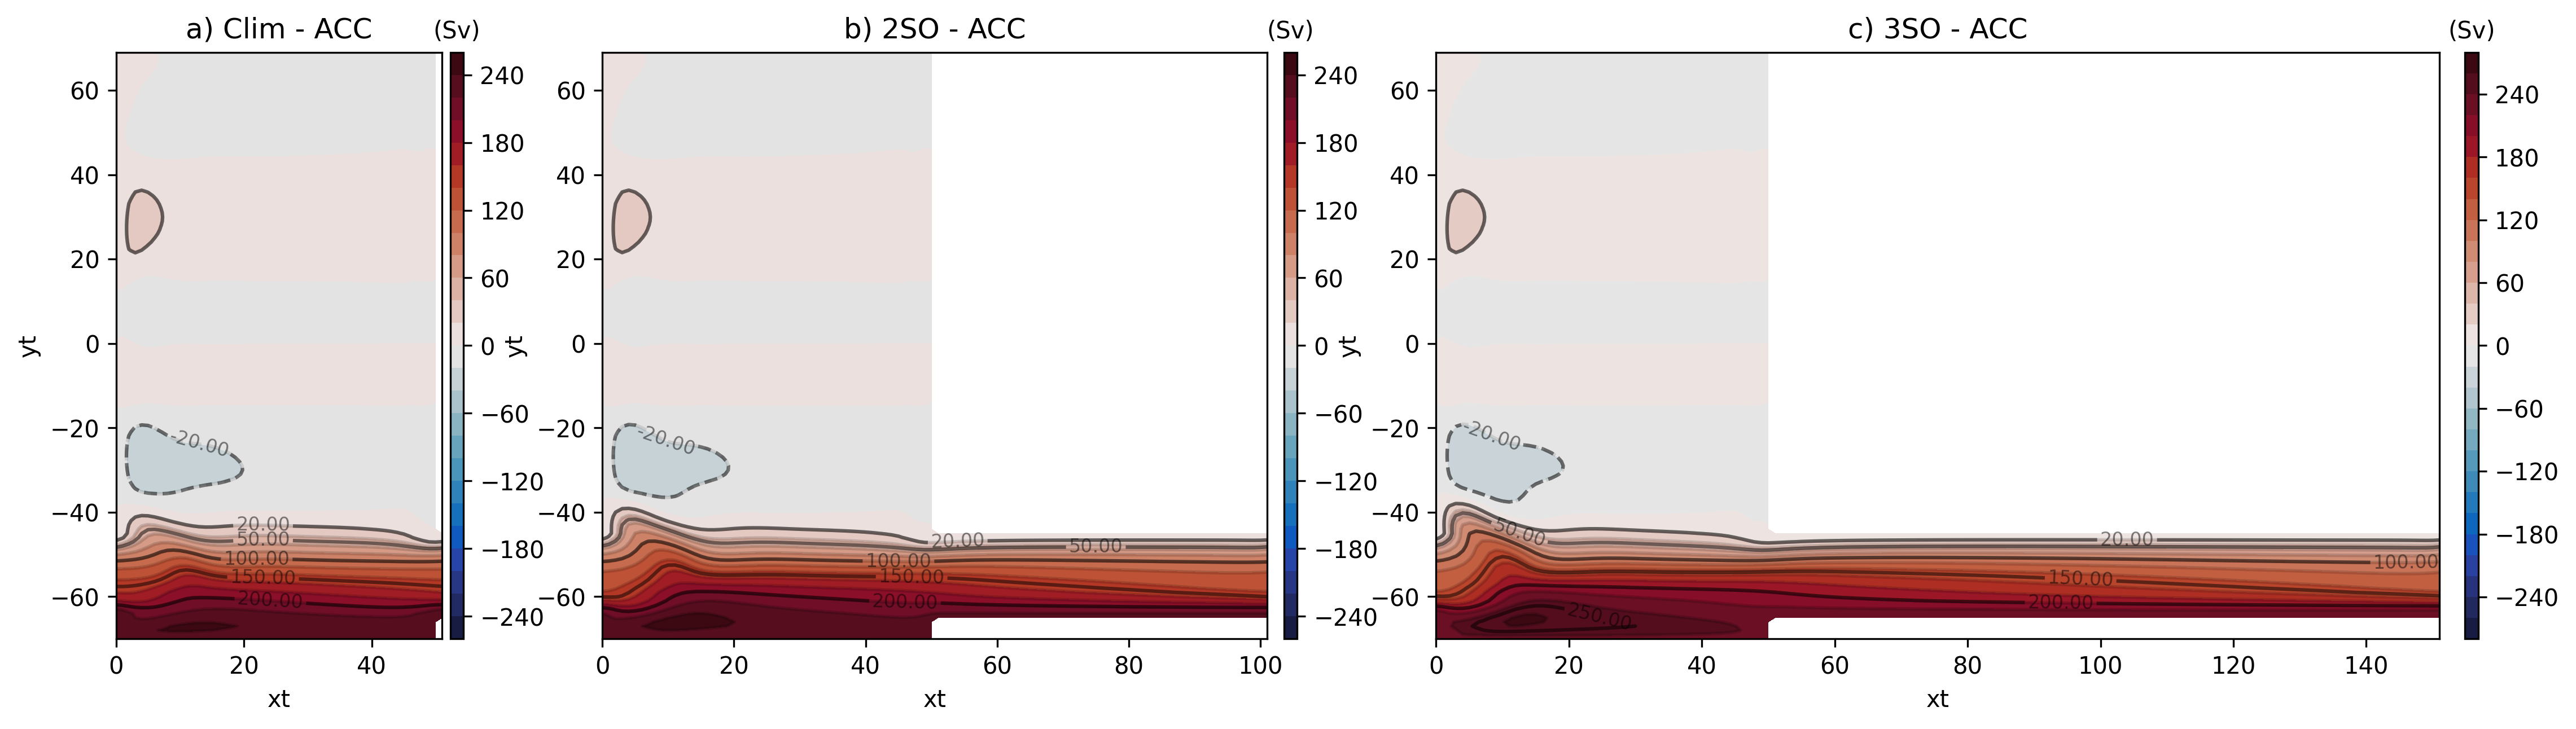

In [12]:
fig = plt.figure(figsize=(18,4.5), dpi=300)

gs = gridspec.GridSpec(1, 3, figure=fig, width_ratios=[1,2,3], height_ratios=[1], hspace = 0.7)

gs1 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[0], width_ratios=[1, 0.04], wspace = 0.05)
ax1 = fig.add_subplot(gs1[0])
cax1 = fig.add_subplot(gs1[1])
contour1 = axis_depth_long_two_fields(ax1, r"$\psi_{bar}$ - ", dict_field_bsf["Clim"], dict_field_bsf["Clim"], span = (-250, 250), 
                                        levels = 26, labeled_levels = [-20, 20, 50, 100, 150, 200, 250], cmap="cmo.balance", neg_pos = True)
fig.colorbar(contour1, cax=cax1, orientation='vertical')

gs2 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[1], width_ratios=[1, 0.02], wspace = 0.05)
ax2 = fig.add_subplot(gs2[0])
cax2 = fig.add_subplot(gs2[1])
contour2 = axis_depth_long_two_fields(ax2, r"$\psi_{bar}$ - ", dict_field_bsf["2SO"], dict_field_bsf["2SO"], span = (-250, 250), 
                                        levels = 26, labeled_levels = [-20, 20, 50, 100, 150, 200, 250], cmap="cmo.balance", neg_pos = True)
fig.colorbar(contour2, cax=cax2, orientation='vertical')



gs3 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[2], width_ratios=[1, 0.04/3], wspace = 0.05)
ax3 = fig.add_subplot(gs3[0])
cax3 = fig.add_subplot(gs3[1])
contour3 = axis_depth_long_two_fields(ax3, r"$\psi_{bar}$ - ", dict_field_bsf["3SO"], dict_field_bsf["3SO"], span = (-275, 275), 
                                        levels = 31, labeled_levels = [-20, 20, 50, 100, 150, 200, 250], cmap="cmo.balance", neg_pos = True)
fig.colorbar(contour3, cax=cax3, orientation='vertical')




titles =[r"a) Clim - ACC", r"b) 2SO - ACC", r"c) 3SO - ACC"]

axs=[ax1, ax2, ax3]

for idx, axis in enumerate(axs) :
    axis.set_ylabel('yt')
    #axis.yaxis.set_label_coords(-0.2,0.5)
    axis.set_xlabel('xt')
    axis.set_title(titles[idx])
    

caxis = [cax1, cax2, cax3]
i=0
for cax in caxis : 
    cax.set_title('(Sv)',fontsize=10.)
    i+=1



plt.tight_layout()
path_to_plot = f"/home/x_titmo/work/analysis/NeverWorld2/plots/report/"
#plt.savefig(path_to_plot + f'NoW_Clim_RMOC_ACC_1000y.png', bbox_inches='tight')

plt.show()

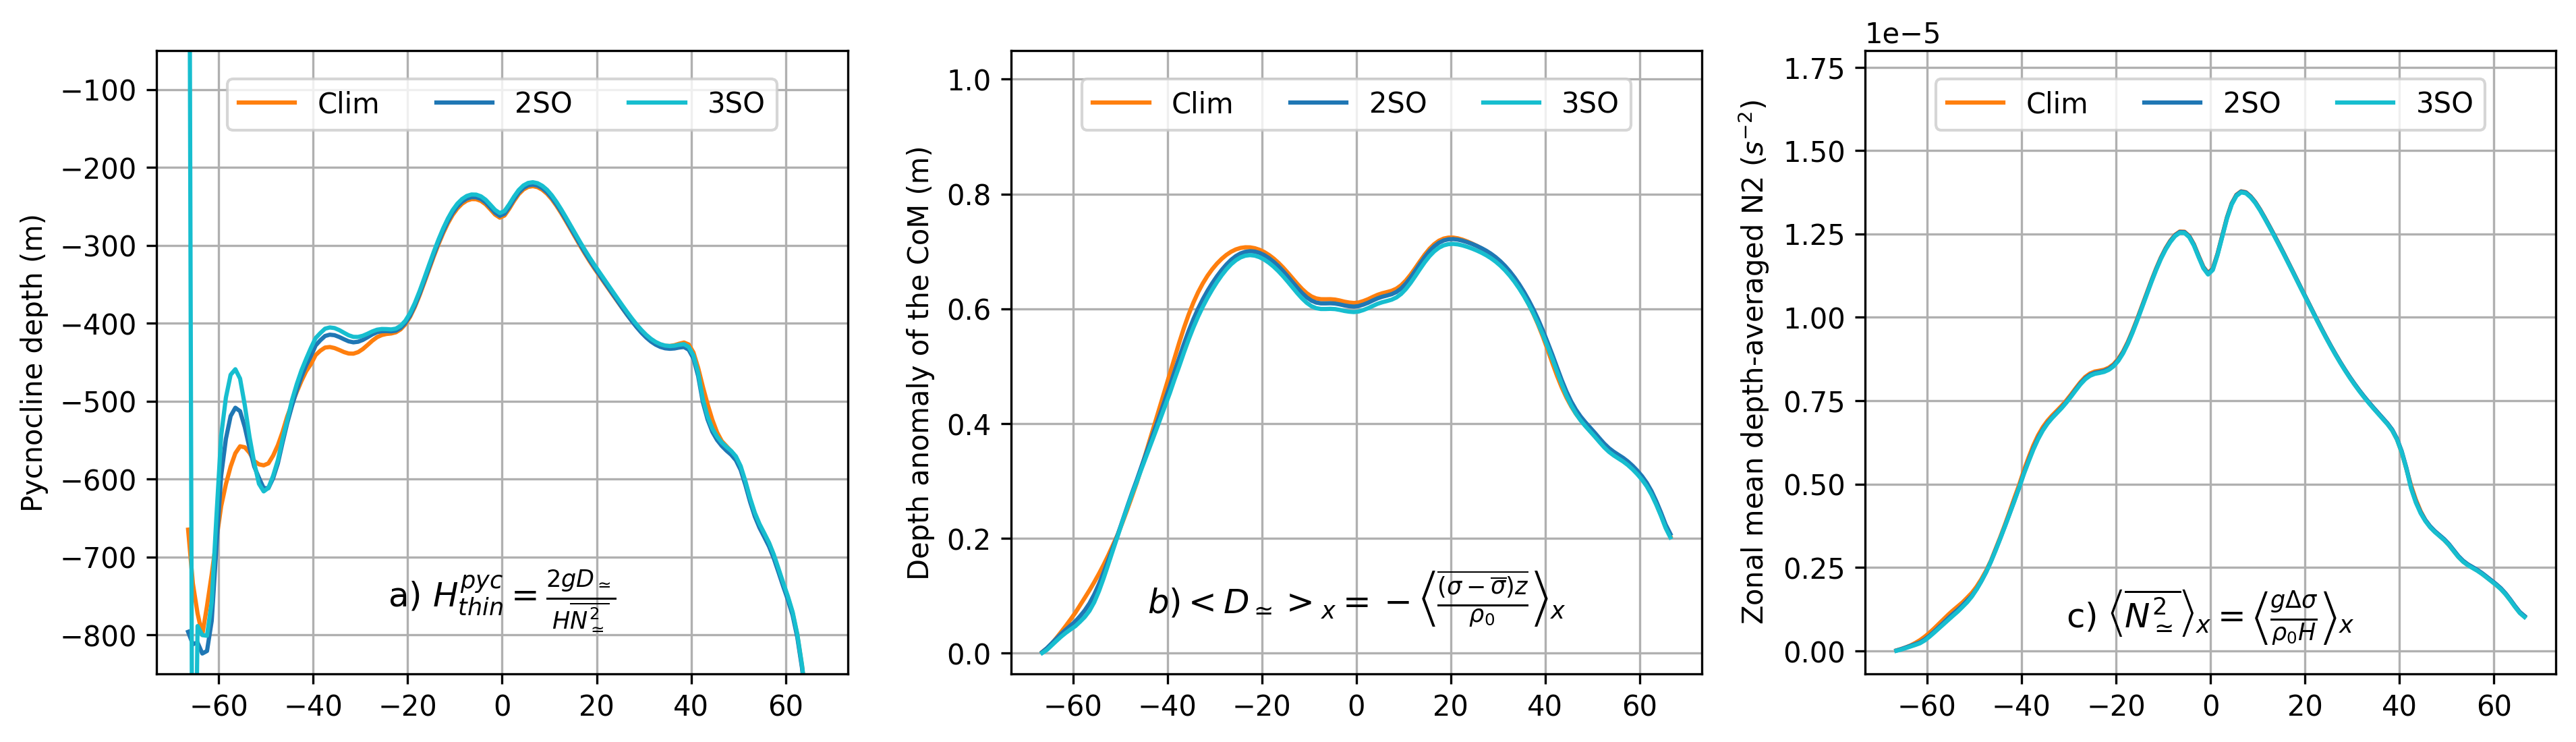

In [21]:
fig = plt.figure(figsize=(17,4), dpi=300)
## BOTTOM
gs_bottom = gridspec.GridSpec(1, 4, figure=fig, width_ratios=[1, 1, 1, 0.15], height_ratios=[1],hspace=0.25, wspace=0.3)

ax1 = fig.add_subplot(gs_bottom[0,0])
ax2 = fig.add_subplot(gs_bottom[0,1])
ax3 = fig.add_subplot(gs_bottom[0,2])

# ax_legend_top = fig.add_subplot(gs_bottom[0,3])  # Empty subplot for the legend
# ax_legend_top.axis("off")  # Hide axes

for idx, key in enumerate(["Clim", "2SO", "3SO",]):
    (dict_pycnocline_4000[key]["H_thin"]).plot(ax=ax1, x='yt', color = style[key]["color"], linestyle = style[key]["linestyle"] , label=key)
    dict_pycnocline_4000[key]["zonavg_depth_anomaly_approx"].plot(ax=ax2, x='yt', color = style[key]["color"], linestyle = style[key]["linestyle"] , label=key) 
    dict_pycnocline_4000[key]["zonavg_mean_N2_approx"].plot(ax=ax3, x='yt', color = style[key]["color"], linestyle = style[key]["linestyle"] , label=key)

# for idx, key in enumerate(["NoW", "2W", "2W_SO", "2W_N"]):
#     (dict_pycnocline_4000[key]["zonavg_depth_anomaly_approx"]- dict_pycnocline_4000["Clim"]["zonavg_depth_anomaly_approx"]).plot(ax=ax2, x='yt', color = style[key]["color"], linestyle = style[key]["linestyle"] , label=key) 
#     (dict_pycnocline_4000[key]["zonavg_mean_N2_approx"]-dict_pycnocline_4000["Clim"]["zonavg_mean_N2_approx"]).plot(ax=ax3, x='yt', color = style[key]["color"], linestyle = style[key]["linestyle"] , label=key)

ax1.text(0, -760, s=r'a) $H_{thin}^{pyc}= \frac{2g D_{\simeq}}{H \overline{N^2_{\simeq}}}$', fontsize=12, ha='center', va='baseline')
ax2.text(0, 0.07, s=r'$b) <D_{\simeq}>_x = - \left<\frac{\overline{(\sigma - \overline{\sigma}) z}}{\rho_0 }\right>_x$', fontsize=12, ha='center', va='baseline')
ax3.text(0, 0.07e-5,s=r'c) $\left<\overline{N^2_{\simeq}}\right>_x = \left<\frac{g \Delta \sigma}{\rho_0 H}\right>_x$', fontsize=12, ha='center', va='baseline')


axs_bottom=[ax1, ax2, ax3,]
titles=['', '', '', '', '', '']
xlabels = ['','','','', '', '']

for idx, axis in enumerate(axs_bottom) :
    axis.set_ylabel(titles[idx])
    axis.set_xlabel(xlabels[idx])
    axis.set_title(xlabels[idx])
    axis.grid()


handles1, labels1 = ax1.get_legend_handles_labels()
# ax_legend_top.legend(handles1, labels1, loc="center", frameon=True)

# no_mark = Line2D([0], [0], marker='.', linestyle='None', color='white', markersize=6, label='')
# handles1, labels1 = [handles1[0], handles1[1],  handles1[2], handles1[3]], [labels1[0], labels1[1], labels1[2], labels1[3]]

ax1.set_ylim(-850,-50), ax2.set_ylim(None,1.05), ax3.set_ylim(None,1.8e-5)

ax1.legend(handles1, labels1, ncols=3, loc='lower center', bbox_to_anchor=(0.5, 0.85))
ax2.legend(handles1, labels1, ncols=3, loc='lower center', bbox_to_anchor=(0.5, 0.85))
ax3.legend(handles1, labels1, ncols=3, loc='lower center', bbox_to_anchor=(0.5, 0.85))

ax1.set_ylabel('Pycnocline depth (m)'), ax2.set_ylabel('Depth anomaly of the CoM (m)'), ax3.set_ylabel(r'Zonal mean depth-averaged N2 ($s^{-2}$)')

plt.tight_layout()
path_to_plot = f"/home/x_titmo/work/analysis/NeverWorld2/plots/report/"
#plt.savefig(path_to_plot + f'Mix_tratification_1000y.png', bbox_inches='tight')

plt.show()


In [14]:
tw = {"NoW": 0, "2W_SO": 2 * 0.2, "2W_N": 1 * 0.2, "2W": 2 * 0.2, 
      "Clim": 1 * 0.2, "Mix_Min": 1 * 0.2, "Mix_Mean": 1 * 0.2, "Mix_Max": 1. * 0.2}
kappaH = {"Mix_Min": 0.3 * 1e-4, "Mix_Mean": .68 * 1e-4, "Mix_Max": 1.26 * 1e-4,
          "Clim": 0.3 * 1e-4, "NoW": 0.3 * 1e-4, "2W_SO": 0.3 * 1e-4, "2W_N": 0.3 * 1e-4, "2W": 0.3 * 1e-4}
L_channel = {'Clim' : 50, '2SO': 100, '3SO' : 150}
space = {"Clim": '    ', "NoW" : '     ',   "Futur" : '   ',
         "2W_SO": '   ',        "2W" : '      ',      "2W_N": '    ',  
         "Mix_Min": ' ', "Mix_Mean" : '', "Mix_Max" : ' ', 
          }

In [15]:
dict_RMOC_cells = {}
for idx, key in enumerate(keys_to_plot):
    if key == "pass":
        continue

    ds_rmoc = dict_field_rmoc[key]
    cell_NA_rmoc = ds_rmoc.where((ds_rmoc.yu>35) & (ds_rmoc.zw>-2000)).max()
    cell_40S_60S_rmoc = ds_rmoc.where((ds_rmoc.yu>-60) & (ds_rmoc.yu<-40)).max()
    cell_bottom_rmoc = ds_rmoc.where((ds_rmoc.yu>-40) & (ds_rmoc.zw<-2000)).min()

    ds_moc = dict_field_moc[key]
    cell_NA_moc = ds_moc.where((ds_moc.yu>35) & (ds_moc.zw>-2000)).max()
    cell_40S_60S_moc = ds_moc.where((ds_moc.yu>-60) & (ds_moc.yu<-40)).max()
    cell_bottom_moc = ds_moc.where((ds_moc.yu>-40) & (ds_moc.zw<-2000)).min()
    
    ds_eddies = dict_field_eddies[key]
    cell_NA_eddies = ds_eddies.where((ds_eddies.yu>35) & (ds_eddies.zw>-2000)).max()
    cell_40S_60S_eddies = ds_eddies.where((ds_eddies.yu>-60) & (ds_eddies.yu<-40)).min()
    cell_bottom_eddies = ds_eddies.where((ds_eddies.yu>-40) & (ds_eddies.zw<-2000)).min()

    dict_RMOC_cells[key] = {"cell_NA_rmoc" : cell_NA_rmoc,
                            "cell_40S_60S_rmoc" : cell_40S_60S_rmoc,
                            "bottom_cell_rmoc" : cell_bottom_rmoc,

                            "cell_NA_moc" : cell_NA_moc,
                            "cell_40S_60S_moc" : cell_40S_60S_moc,
                            "bottom_cell_moc" : cell_bottom_moc,

                            "cell_NA_eddies" : cell_NA_eddies,
                            "cell_40S_60S_eddies" : cell_40S_60S_eddies,
                            "bottom_cell_eddies" : cell_bottom_eddies,
                            }


dict_ACC = {}
for idx, key in enumerate(keys_to_plot):
    if key == "pass":
        continue

    trans_ACC = dict_field_bsf[key].where(dict_field_bsf[key].yu<-40).max()
    dict_ACC[key] = trans_ACC


In [16]:
Glob_H_thin = {}
Glob_H_gna = {}
for key in keys_to_plot:
    ds = dict_pycnocline_4000[key]["H_thin_map"]
    ds_gna = dict_pycnocline_4000[key]["pic_gna"]
    Glob_H_thin[key] = ds.where((ds.yt<40) & (ds.yt>-40)).weighted(weight_xyz_t).mean(dim=("xt", "yt", "zt"))
    Glob_H_gna[key] = -ds_gna.where((ds_gna.yt<40) & (ds_gna.yt>-40)).weighted(weight_xyz_t).mean(dim=("xt", "yt", "zt"))

    print(Glob_H_thin[key].values, Glob_H_gna[key].values)

-338.21195443744955 -636.0784304336562
-335.13047026263666 -611.4692190582886
-331.2716930080835 -603.586815011935


In [17]:
g = 9.81
rho_0 = 1024.
degtorad = np.pi / 180.0

Lx = 6370e3 * 50 * degtorad # Zonal Channel extent
Lc = 6370e3 * 20 * degtorad # Meridionnal Channel extent
Ly = 6370e3 * 80 * degtorad # Zonal Bassin extent

# omega = np.pi / 43082.0
# f = 2 * omega * np.sin(45 * degtorad) 
# print(rf'f = {f:e} /s')
f=1e-4

A = 50 * degtorad * (np.sin(70 * degtorad) + np.sin(70 * degtorad)) * (6370e3) ** 2 
print(rf'A = {A:e} m^2')
#A =2.44e14

print(Lx * Ly / A)

K_GM = 1000. ## Arbitrary, to be modified/choose carefully

A = 6.654908e+13 m^2
0.7429362382497502


In [18]:
# Physical constants
delta_rho = 2.2

# Parameter ranges
tau_values = np.linspace(0, 2, 21) * 0.2
K_GM_values = np.linspace(0, 3000, 31) 
kappa_H_values = np.linspace(3.05, 13.05, 101) * 1e-5
Lx_values = np.linspace(50,150,26) 

 
# Empty 3D arrays for D and psi
D_solved_array = np.full((len(tau_values), len(K_GM_values), len(kappa_H_values), len(Lx_values)), np.nan)
psi_solved_array = np.full_like(D_solved_array, np.nan)

# Loop through parameter combinations
for i, tau in enumerate(tau_values):
    for j, K_GM in enumerate(K_GM_values):
        for k, kappa_H in enumerate(kappa_H_values):
            for l, Lx in enumerate(Lx_values):
                Lx = Lx * 6370e3 * np.pi / 180.0
                delta_buoy = g * delta_rho / rho_0 

                a = delta_buoy / f
                b = K_GM * Lx / Lc
                c = -tau * Lx / (rho_0 * f)
                d = -kappa_H * Lx * Ly
                
                roots = np.roots([a, b, c, d])
                real_roots = [r.real for r in roots if np.isreal(r) and r.real > 0]
                
                if real_roots:
                    D_solved = -real_roots[0]
                    D_solved_array[i, j, k, l] = D_solved
                    #psi_solved = (tau * Lx / (rho_0 * f) - K_GM * Lx * D_solved / Lc ) * 1e-6
                    psi_solved = D_solved**2 * delta_buoy / f * 1e-6
                    psi_solved_array[i, j, k, l] = psi_solved

# Wrap in xarray
D_xr = xr.DataArray(D_solved_array, coords={'tau': tau_values,'K_GM': K_GM_values,'kappa_H': kappa_H_values, 'Lx': Lx_values}, dims=['tau', 'K_GM', 'kappa_H', 'Lx'],)

psi_xr = xr.DataArray(psi_solved_array, coords={'tau': tau_values,'K_GM': K_GM_values,'kappa_H': kappa_H_values, 'Lx': Lx_values}, dims=['tau', 'K_GM', 'kappa_H', 'Lx'],)


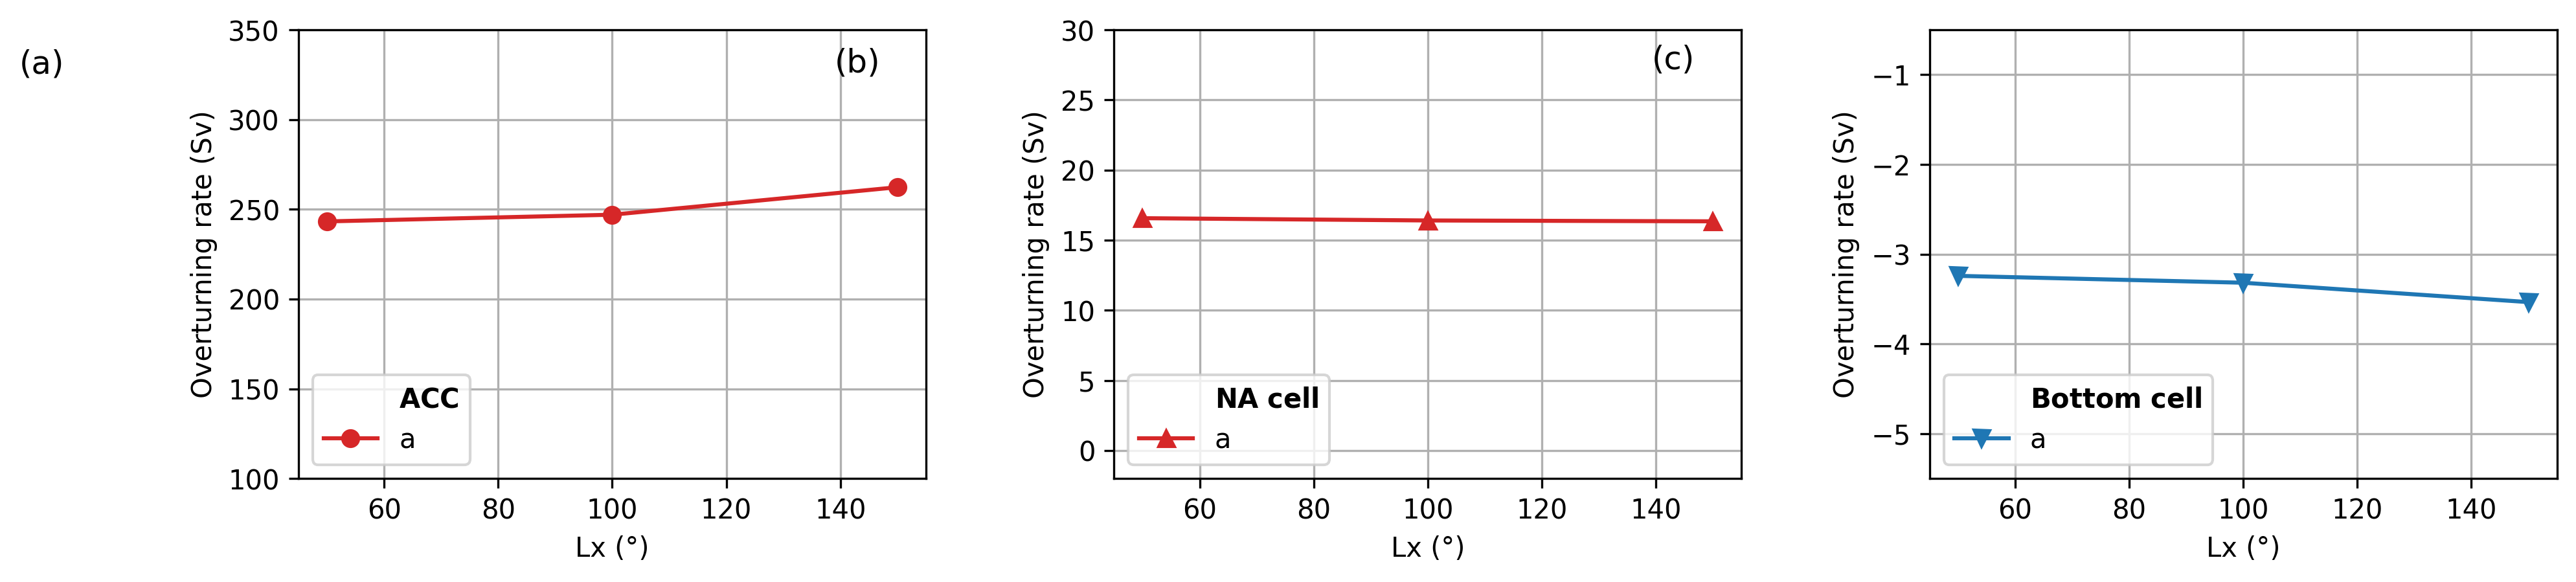

In [19]:
fig = plt.figure(figsize=(15,3), dpi=300)
gs_bottom = gridspec.GridSpec(1, 3, figure=fig, height_ratios=[1], width_ratios=[1,1,1], hspace=0.05, wspace=0.3)

## BOTTOM
ax1 = fig.add_subplot(gs_bottom[0])
ax2 = fig.add_subplot(gs_bottom[1])
ax3 = fig.add_subplot(gs_bottom[2])

### DIFUSIVITY PLOTS
key_SO = ["Clim", "2SO", "3SO"]

## RMOC cells
ax2.plot(np.array([L_channel[k] for k in key_SO]), np.array([dict_RMOC_cells[k]["cell_NA_rmoc"] for k in key_SO]), marker='^', color='tab:red', label = "a", zorder=2)
ax3.plot(np.array([L_channel[k] for k in key_SO]), np.array([dict_RMOC_cells[k]["bottom_cell_rmoc"] for k in key_SO]), marker='v', color='tab:blue', label = "a", zorder=2)

## ACC
ax1.plot(np.array([L_channel[k] for k in key_SO]), np.array([dict_ACC[k] for k in key_SO]), marker='o', color='tab:red', linestyle='solid', label = "a", zorder=2)

# key_all_Mix = ["Clim", "Mix_Min", "Mix_Mean", "Mix_Max"]
# ax1.scatter(np.array([kappaH[k] for k in key_all_Mix]), np.array([D_scale[k]["D_solved"] for k in key_all_Mix]), marker='x', color='tab:orange', label = "D scaling", zorder=3)

# psi_xr.sel(K_GM=1300.).sel(kappa_H = 0.305 * 1e-4, method='nearest').sel(tau =0.2, method='nearest').plot(ax=ax2, x='Lx', color='tab:orange', label=rf'Scaling')
# psi_xr.sel(K_GM=1300.).sel(kappa_H = 0.65 * 1e-4, method='nearest').sel(tau =0.2, method='nearest').plot(ax=ax2, x='Lx', color='tab:orange', label=rf'Scaling')

handles_ax1, labels_ax1 = ax1.get_legend_handles_labels()
handles_ax2, labels_ax2 = ax2.get_legend_handles_labels()
handles_ax3, labels_ax3 = ax3.get_legend_handles_labels()

no_mark = Line2D([0], [0], marker='.', linestyle='None', color='white', markersize=6, label='')

handles_ax1 = [no_mark, handles_ax1[0]]
labels_ax1 =  [r"$\bf{ACC}$", labels_ax1[0]]

handles_ax2 = [no_mark, handles_ax2[0]]#, handles_ax2[1]]
labels_ax2 =  [r"$\bf{NA ~ cell}$", labels_ax2[0]]#, labels_ax2[1]]

handles_ax3 = [no_mark, handles_ax3[0]]
labels_ax3 =  [r"$\bf{Bottom ~ cell}$", labels_ax3[0]]


axs_bottom=[ax1, ax2, ax3]
xlabels=[r'Lx (°)', r'Lx (°)', r'Lx (°)']
titles= ["Overturning rate (Sv)", "Overturning rate (Sv)", "Overturning rate (Sv)",]
for idx, axis in enumerate(axs_bottom) :
    axis.set_ylabel(titles[idx])
    axis.set_xlabel(xlabels[idx])
    axis.grid()
    axis.set_title('')



ax1.legend(handles_ax1, labels_ax1, ncols=1, loc='lower left', bbox_to_anchor=(0.001, .001))
ax2.legend(handles_ax2, labels_ax2, ncols=1, loc='lower left', bbox_to_anchor=(0.001, .001))
ax3.legend(handles_ax3, labels_ax3, ncols=1, loc='lower left', bbox_to_anchor=(0.001, .001))

ax1.set_ylim(100,350)
ax2.set_ylim(-2,30)
ax3.set_ylim(-5.5,-0.5)

ax1.text(0.3e-4, 326, s=r'(a)', fontsize=12, ha='center', va='baseline')
ax2.text(0.3e-4, 27, s=r'(b)', fontsize=12, ha='center', va='baseline')
ax3.text(0.3e-4, -0.93, s=r'(c)', fontsize=12, ha='center', va='baseline')

plt.tight_layout()
path_to_plot = f"/home/x_titmo/work/analysis/NeverWorld2/plots/report/"
#plt.savefig(path_to_plot + f'Mixs_transport_scaling.png', bbox_inches='tight')

plt.show()

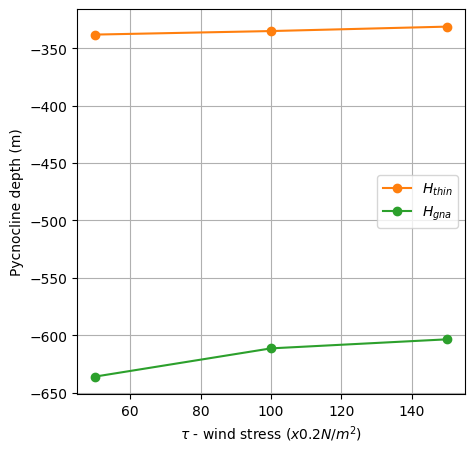

In [20]:
fig = plt.figure(figsize=(5,5.))
gs_bottom = gridspec.GridSpec(1, 1, figure=fig, height_ratios=[1], width_ratios=[1], hspace=0.05, wspace=0.5)

## BOTTOM

ax4 = fig.add_subplot(gs_bottom[0])

### DIFUSIVITY PLOTS
key_SO = ["Clim", "2SO", "3SO"]

#Scaling
#D_xr.sel(K_GM=1000.).sel(tau =0.2, method='nearest').where(D_xr.kappa_H<1.3 *1e-4).plot(ax=ax4, x='kappa_H', color='tab:blue', label=rf'Scaling')

## Global mean H_thin
ax4.plot(np.array([L_channel[k] for k in key_SO]), np.array([Glob_H_thin[k] for k in key_SO]), marker='o', color='tab:orange', linestyle='solid', label = r"$H_{thin}$", zorder=2)

## Global mean H_thin
ax4.plot(np.array([L_channel[k] for k in key_SO]), np.array([Glob_H_gna[k] for k in key_SO]), marker='o', color='tab:green', linestyle='solid', label = r"$H_{gna}$", zorder=2)

handles_ax4, labels_ax4 = ax4.get_legend_handles_labels()
no_mark = Line2D([0], [0], marker='.', linestyle='None', color='white', markersize=6, label='')
handles_ax4 = [handles_ax4[0], handles_ax4[1]]
labels_ax4 =  [labels_ax4[0] , labels_ax4[1]]


axs_bottom=[ax4]
xlabels=[r'$\tau$ - wind stress $(x 0.2 N/m^2)$', r'Vertical diffusivity (x$10^{-4}m^2.s^{-1}$)']
titles= ["Pycnocline depth (m)", "Pycnocline depth (m)"]
for idx, axis in enumerate(axs_bottom) :
    axis.set_ylabel(titles[idx])
    axis.set_xlabel(xlabels[idx])
    axis.grid()
    axis.set_title('')

#ax2.set_ylim(-500,-350)
ax4.legend(handles_ax4, labels_ax4, ncols=1, loc='center right',  bbox_to_anchor=(1.,0.5))


#ax4.text(1.25e-4, -250, s=r'(b)', fontsize=12, ha='center', va='baseline')

plt.tight_layout()
path_to_plot = f"/home/x_titmo/work/analysis/NeverWorld2/plots/report/"
#plt.savefig(path_to_plot + f'Pycnocline_depths_scaled.png', bbox_inches='tight')

plt.show()